In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optim
import graphics

from grid import Grid
from data import Data
from forward import Forward
from optimize_list import Optimize_list


First, we set up the experiment parameters. 
We choose an image resolution of 50x 50 pixels. 
The protein has a length of 214 $C-\alpha$ atoms. 
We choose a forward model Gaussian sd of 2.0 and a noise level of 1.0 

We discretize the protein path into 100 steps. Time step size is $h = 0.01$

We begin by using projections in the x, y and z directions. 

In [2]:
np.random.seed(0)

# Grid params
res = 50
span = 50
# Protein params
N = 214#1000
blob_size= 2.0
noise_level = 1.0
# Opt params
h = 0.01


grid = Grid(res, span) #create grid
forward = Forward() #create forward model, use ONLY x, y, z for now

data = Data(N, grid,forward_model = forward, blob_size=blob_size, noise_sigma=noise_level) # create data 
optimize = Optimize_list(data,h) #create optimization problem 

SnRs = np.array([np.var(image)/noise_level**2 for image in data.target_projections_blur_nb])
average_SnR = np.mean(SnRs)
print(average_SnR)
print(SnRs)
print(10*np.log10(average_SnR))
print(10*np.log10(SnRs))
print(np.mean(10*np.log10(SnRs)))

/Users/erikjans/miniforge3/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


0.003033389078958167
[0.00321403 0.00251603 0.00337011]
-25.180718811475373
[-24.92950044 -25.99283866 -24.72356547]
-25.21530152026963


As a preprocessing step for the later optimization algorithm, we determine a starting guess by running gradient descent for a few steps. We first initalize the variable 'u_full' as all zeros, and then run 50 gd steps with an lr of 1e-5. 

In [3]:
u_full = np.zeros((100,N,3,3))
print(optimize.F(u_full))
for j in range(50):
    u_full = u_full- 0.0001*optimize.grad(u_full)
    if j%10 == 0: print(optimize.F(u_full))

7328.832651220597
7328.586383149592
7326.527645371352
7323.359179523939
7321.606373434566
7320.7739768423835


Now we put the forward model and its exact gradient into a scipy-readable format and run the L-BFGS-B algorithm. 

In [4]:
def fg(vec):
    v = vec.reshape((100,N,3,3))
    f = optimize.F(v)
    g = optimize.grad(v)/N
    return (f,g.flatten())

def callback(x):
    print(f"Current solution: {x}")


out = optim.minimize(fg,u_full.flatten(),jac = True, method = 'L-BFGS-B', options = {'ftol': 1e-25,'gtol':1e-25},callback=callback)
print(out)

Current solution: [ 0.00000000e+00  3.43118807e-02  7.95910829e-02 ...  8.33820748e-04
 -3.51832885e-04  2.10311240e-23]
Current solution: [ 0.00000000e+00  7.98358863e-02  1.63202452e-01 ...  3.00307339e-03
 -1.75633242e-03  5.72057415e-23]
Current solution: [ 0.00000000e+00  7.88767028e-02  1.60851374e-01 ...  3.18970455e-03
 -1.93898177e-03  6.45920994e-23]
Current solution: [ 0.00000000e+00  6.26728829e-02  1.26834294e-01 ...  3.36171301e-03
 -2.24167080e-03 -4.95884686e-23]
Current solution: [ 0.00000000e+00  6.26728829e-02  1.26834294e-01 ...  3.36171301e-03
 -2.24167080e-03 -4.95884686e-23]
      fun: 7313.897786960968
 hess_inv: <192600x192600 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -3.08510517e-03, -1.92156718e-02, ...,
       -2.62156793e-05,  4.45183983e-04, -3.79977397e-22])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 49
      nit: 5
     njev: 49
   status: 0
  success: True
        x: array([ 0.00000000e+00,  

Now extract the found algebra path and deform the template. Plot the target, template and deformed template. 

In [5]:
u_full = out.x.reshape((100,N,3,3))
R_full = optimize.euler(u_full)


R1 = R_full[-1]
template_model = data.template_model
def_model = forward.act(R1, template_model)
def_model_pc = forward.M(def_model)

da = forward.M(def_model)
da1 = forward.M(data.template_model)
da2 = data.target_pc



(<Figure size 1000x1000 with 1 Axes>, <Axes3DSubplot:>)

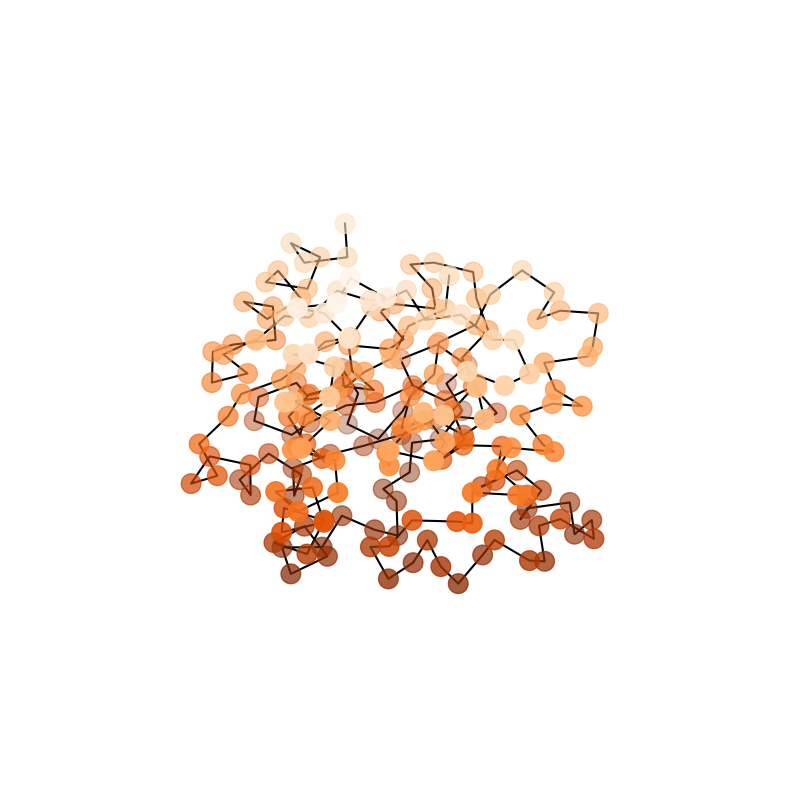

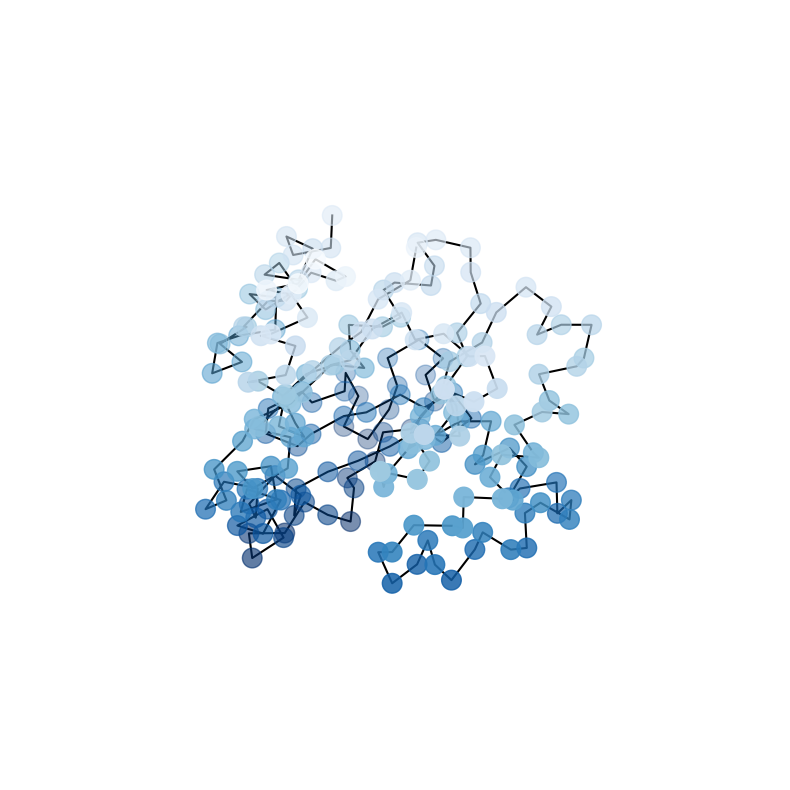

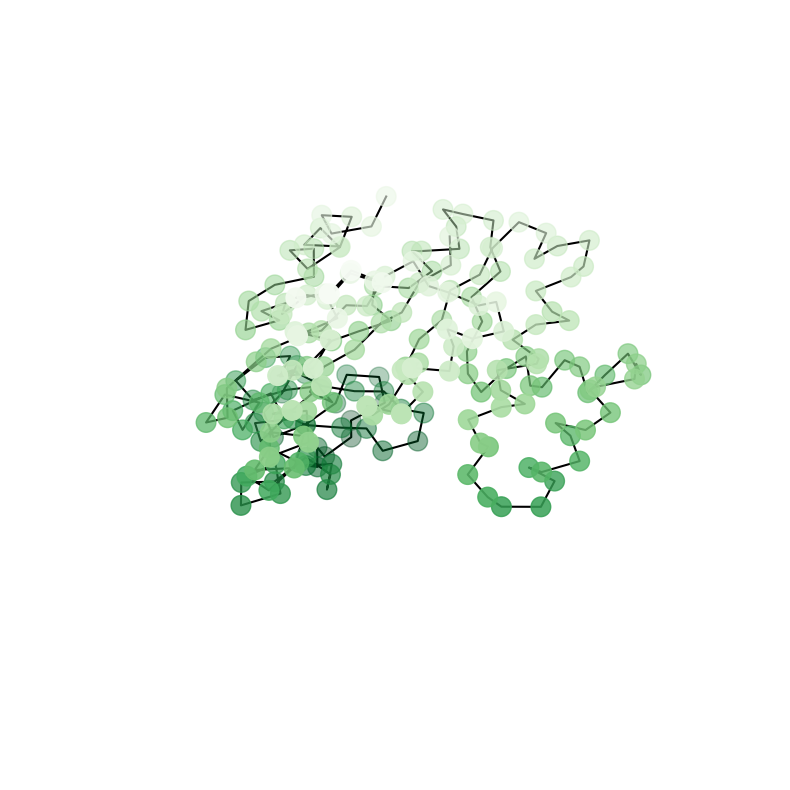

In [6]:
graphics.spaceplot(da1,'Oranges_r', save = True, filename = 'template.pdf',dpi = 150)

graphics.spaceplot(da,'Blues_r', save = True, filename = 'deformed_3d.pdf',dpi = 150)

graphics.spaceplot(da2,'Greens_r', save = True, filename = 'target.pdf',dpi = 150)

It does not look too good! But let's look at the projection images of the deformed proteins. 

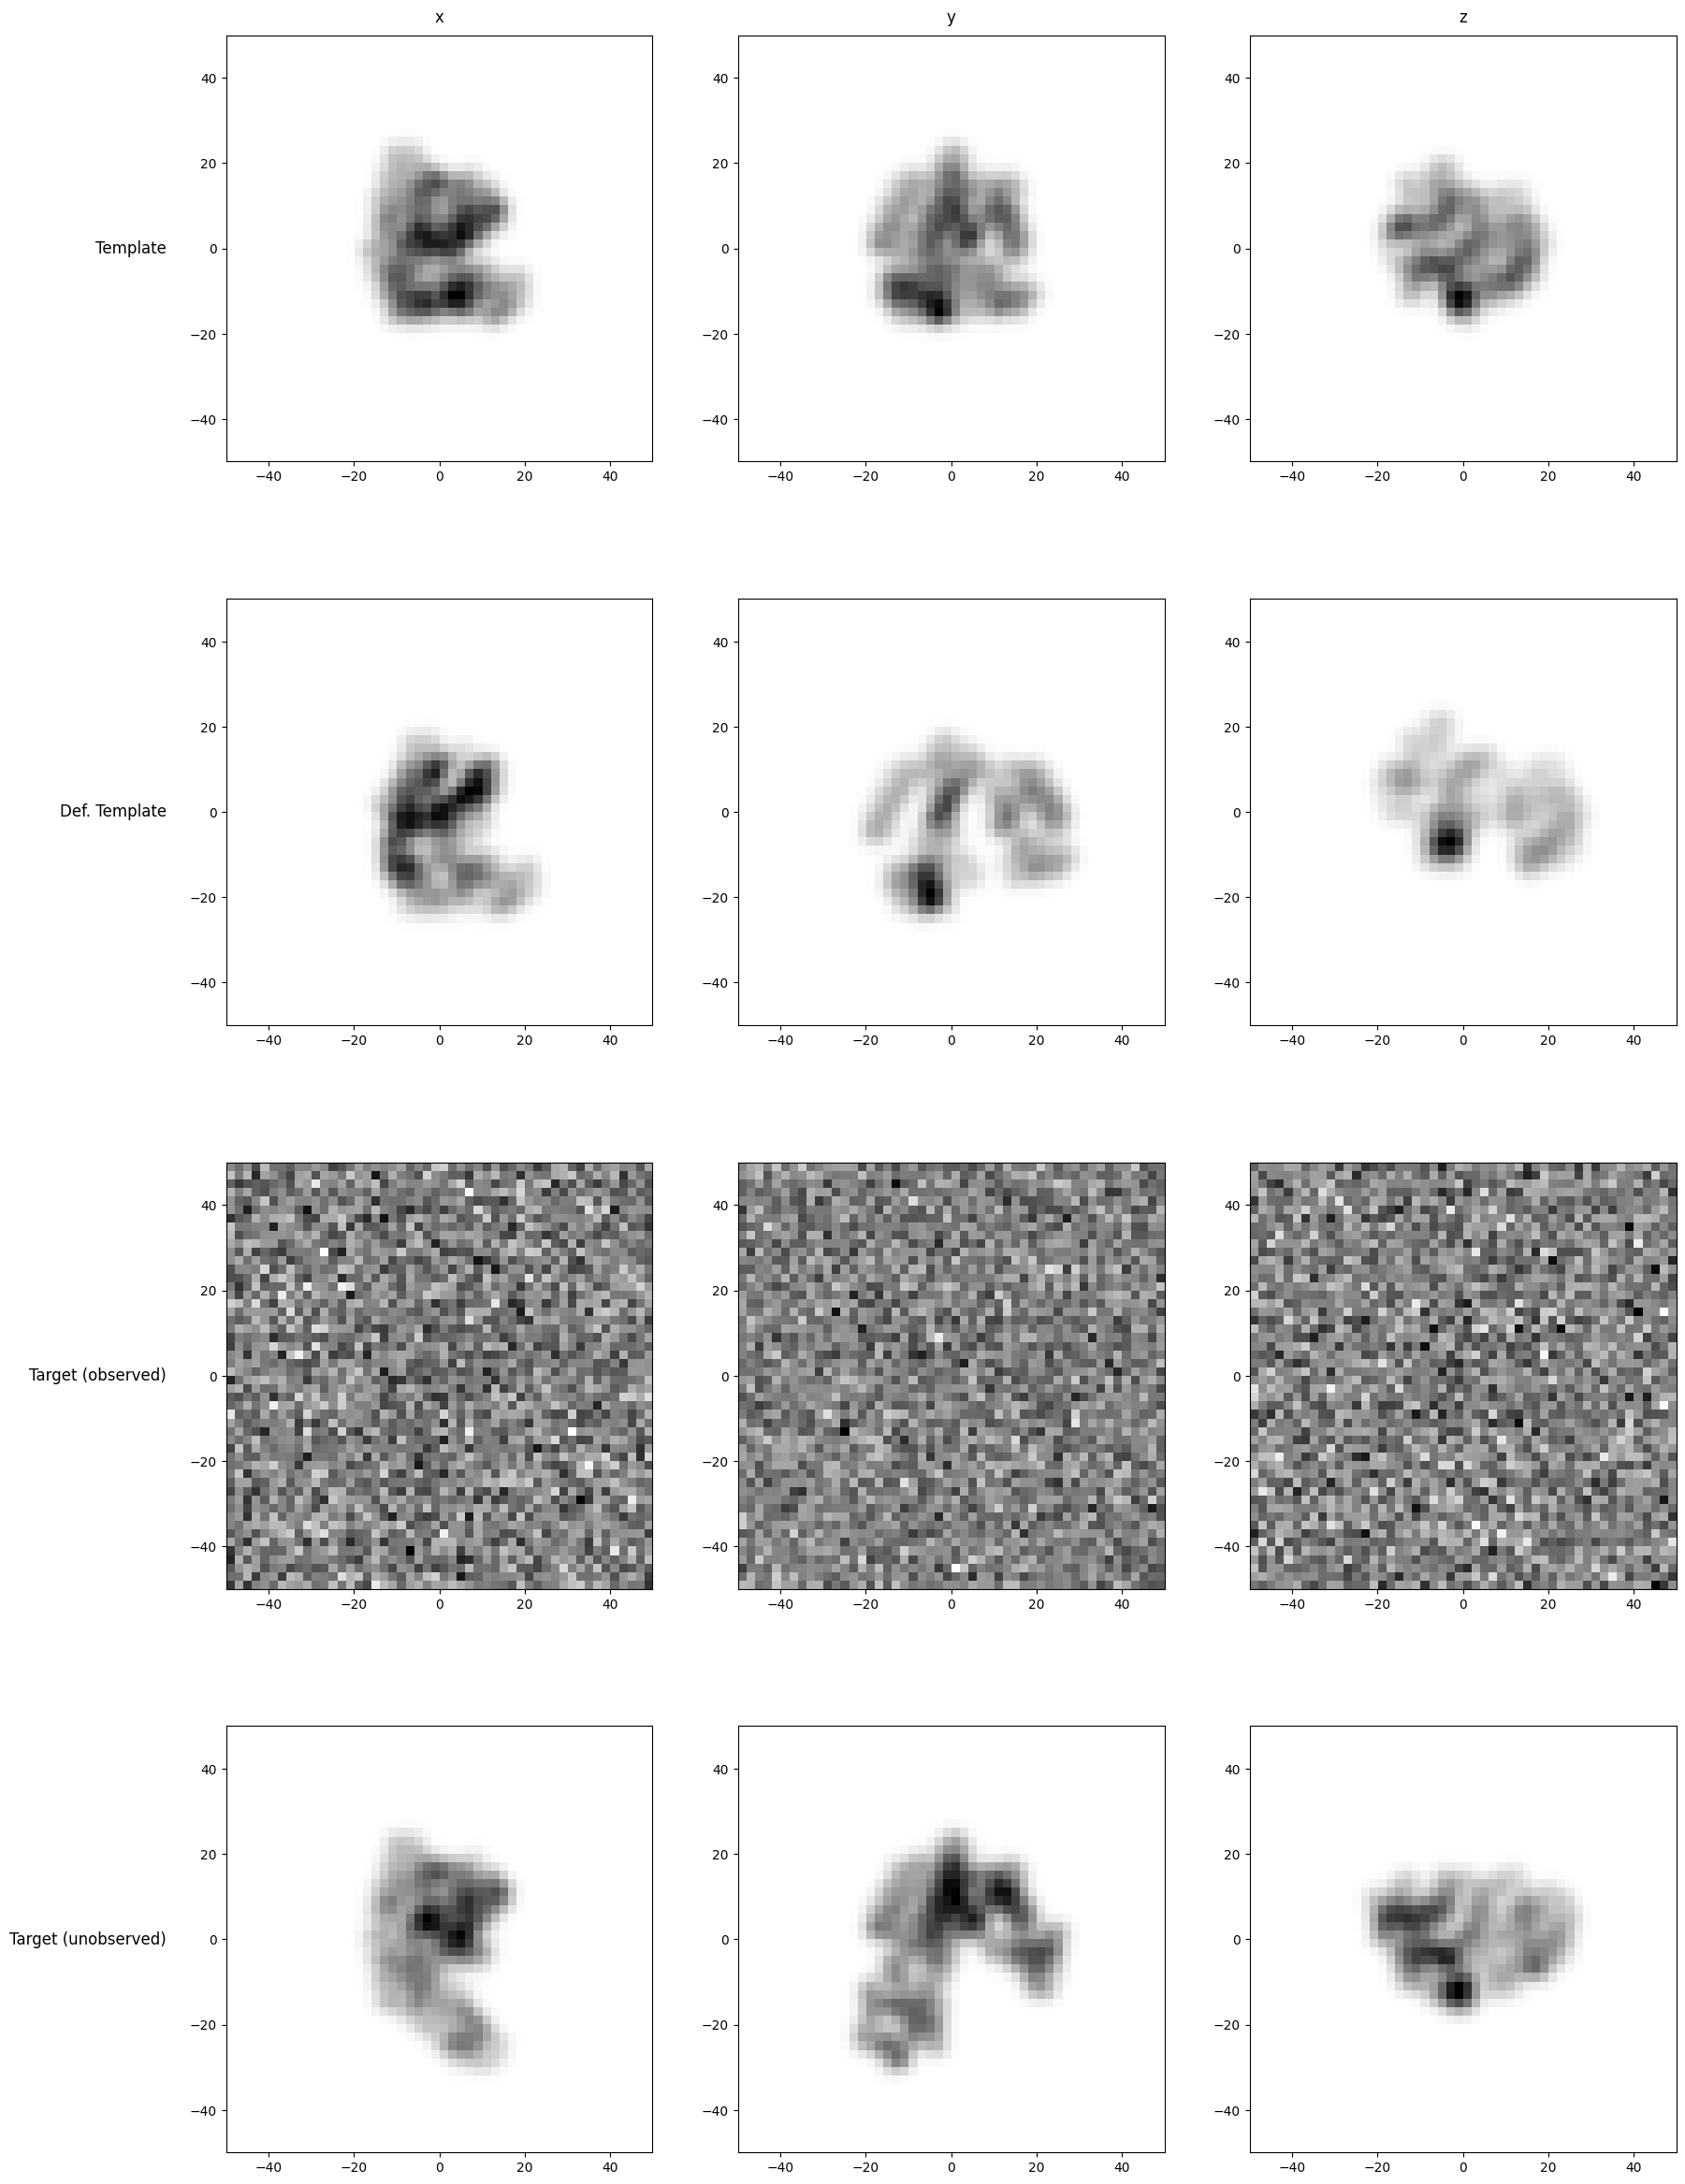

In [7]:
def_x = forward.blur(forward.project(da,forward.projections[0]), grid, blob_size)
def_y = forward.blur(forward.project(da,forward.projections[1]), grid, blob_size)
def_z = forward.blur(forward.project(da,forward.projections[2]), grid, blob_size)

template_x = data.template_projections_blur[0]
template_y = data.template_projections_blur[1]
template_z = data.template_projections_blur[2]

target_noblur_x = data.target_projections_blur_nb[0]
target_noblur_y = data.target_projections_blur_nb[1]
target_noblur_z = data.target_projections_blur_nb[2]


target_x = data.target_projections_blur[0]
target_y = data.target_projections_blur[1]
target_z = data.target_projections_blur[2]

shape = (4,3)
rows = ['Template','Def. Template','Target (observed)', 'Target (unobserved)']
cols = ['x','y','z']

image_dict = {(0,0): template_x,
             (0,1): template_y,
             (0,2): template_z,
             (1,0): def_x,
             (1,1): def_y,
             (1,2): def_z,
             (2,0): target_x,
             (2,1): target_y,
             (2,2): target_z,
             (3,0): target_noblur_x,
             (3,1): target_noblur_y,
             (3,2): target_noblur_z}
fig,ax = graphics.imagegridplot(image_dict,shape,span, colnames = cols, rownames =rows,save = True, filename = '3dres.pdf',dpi = 150)

What do we conclude from these plots? That we manage a decent recostrunctions in the directions we project. We are therefore going to repeat the process with more projection images. 

/Users/erikjans/miniforge3/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


Current solution: [ 0.00000000e+00 -1.08410361e-02 -1.70600373e-02 ... -9.66639760e-03
 -9.56172427e-04  1.11553107e-22]
Current solution: [ 0.00000000e+00  1.55523317e-03  3.60322230e-02 ... -9.91808861e-03
 -9.91380886e-04 -2.54191141e-23]
Current solution: [ 0.00000000e+00  2.80158317e-03  3.00704609e-02 ... -1.00161193e-02
 -9.59608973e-04 -6.76299123e-23]
Current solution: [ 0.00000000e+00  2.75097634e-03  2.64101946e-02 ... -1.01762260e-02
 -9.74336955e-04 -1.08467984e-22]
Current solution: [ 0.00000000e+00 -4.73499251e-03  4.08960061e-03 ... -1.03322386e-02
 -1.00629991e-03 -1.40533537e-22]
Current solution: [ 0.00000000e+00 -5.98977939e-03 -3.79112859e-03 ... -1.05540121e-02
 -9.46486147e-04 -4.51297178e-23]
Current solution: [ 0.00000000e+00 -7.20075887e-03 -7.33448870e-03 ... -1.07920412e-02
 -8.53451220e-04 -6.17948697e-23]
Current solution: [ 0.00000000e+00 -1.02243551e-02 -1.53300941e-02 ... -1.25416735e-02
 -2.04559880e-04 -3.68351464e-22]
Current solution: [ 0.00000000e+

Current solution: [ 0.00000000e+00  2.85602118e-02  9.49695206e-02 ... -2.57195244e-02
  1.52872199e-02  3.83832193e-20]
Current solution: [ 0.00000000e+00  2.57838309e-02  8.82941327e-02 ... -2.54655293e-02
  1.66687257e-02  4.09614608e-20]
Current solution: [ 0.00000000e+00  2.59645491e-02  8.83486164e-02 ... -2.53411667e-02
  1.70406101e-02  4.11968645e-20]
Current solution: [ 0.00000000e+00  2.62636241e-02  8.90356942e-02 ... -2.53447849e-02
  1.71671482e-02  4.15056878e-20]
Current solution: [ 0.00000000e+00  2.67613940e-02  9.01107641e-02 ... -2.53490442e-02
  1.74323699e-02  4.14379205e-20]
Current solution: [ 0.00000000e+00  2.90688613e-02  9.52040503e-02 ... -2.54427896e-02
  1.82199571e-02  3.99948535e-20]
Current solution: [ 0.00000000e+00  3.05999527e-02  9.82277882e-02 ... -2.54883731e-02
  2.00282341e-02  4.29423216e-20]
Current solution: [ 0.00000000e+00  3.16059443e-02  1.00131359e-01 ... -2.54865072e-02
  2.14101959e-02  4.64369441e-20]
Current solution: [ 0.00000000e+

(<Figure size 1000x1000 with 1 Axes>, <Axes3DSubplot:>)

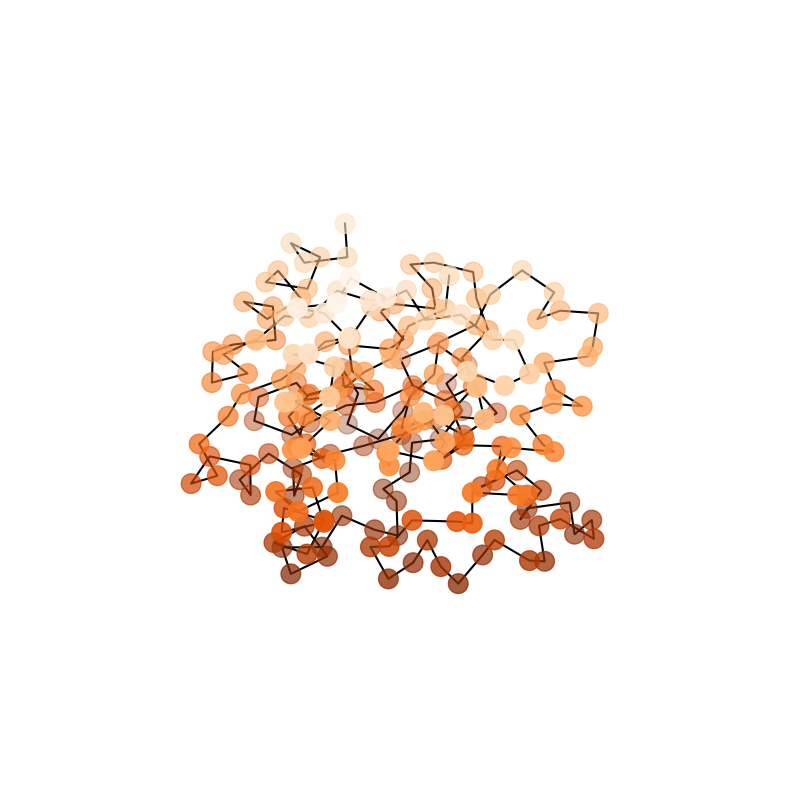

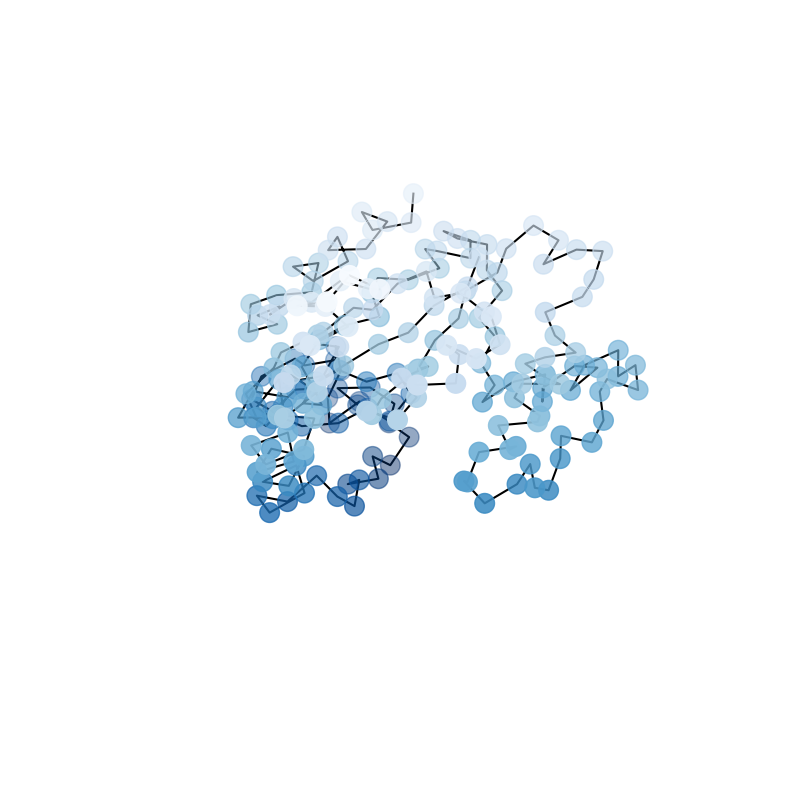

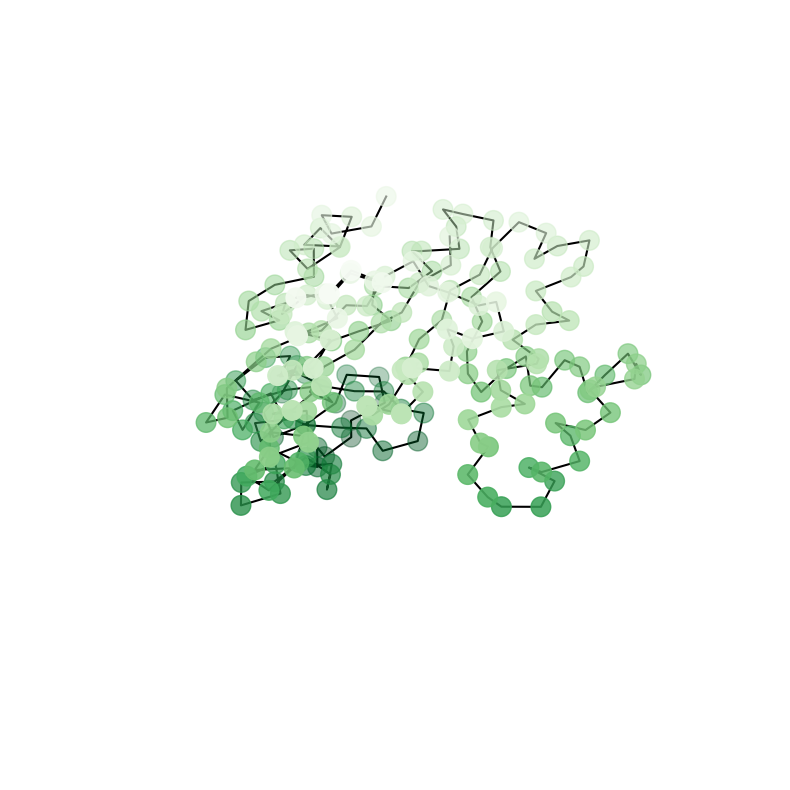

In [8]:
from scipy.spatial import procrustes 

# Grid params
res = 50
span = 50
# Protein params
N = 214#1000
blob_size= 2.0
noise_level = 1.0
# Opt params
h = 0.01

No_projections = 300

grid = Grid(res, span) #create grid
np.random.seed(123)
forward = Forward(No_projections) #create forward model, use ONLY x, y, z for now

np.random.seed(0)
data = Data(N, grid,forward_model = forward, blob_size=blob_size, noise_sigma=noise_level) # create data 

optimize = Optimize_list(data,h) #create optimization problem 

u_full = np.zeros((100,N,3,3))

for j in range(50):
    u_full = u_full- 0.0001*optimize.grad(u_full)
    
out = optim.minimize(fg,u_full.flatten(),jac = True, method = 'L-BFGS-B', options = {'ftol': 1e-25,'gtol':1e-25},callback=callback)
u_full = out.x.reshape((100,N,3,3))
R_full = optimize.euler(u_full)


R1 = R_full[-1]
template_model = data.template_model
def_model = forward.act(R1, template_model)
def_model_pc = forward.M(def_model)

da = forward.M(def_model)
da1 = forward.M(data.template_model)
da2 = data.target_pc

graphics.spaceplot(da1,'Oranges_r')

graphics.spaceplot(da,'Blues_r', save = True, filename = 'deformed_300images.pdf',dpi = 150)

graphics.spaceplot(da2,'Greens_r')


In [9]:
from scipy.spatial import procrustes 



M = 20
L = 10
scores = np.zeros((L,M))
for i in range(L):
    No_projections = int(2**i)
    print("running for:"+ str(2**i)+" projection images")
    for m in range(M):
        np.random.seed(0)
        forward = Forward(No_projections) 

        np.random.seed(i*1000+m*100*i)
        data = Data(N, grid,forward_model = forward, blob_size=blob_size, noise_sigma=noise_level) # create data 
    
        optimize = Optimize_list(data,h) #create optimization problem 

        u_full = np.zeros((100,N,3,3))

        for j in range(50):
            u_full = u_full- 0.00001*optimize.grad(u_full)

        out = optim.minimize(fg,u_full.flatten(),jac = True, method = 'L-BFGS-B', options = {'ftol': 1e-25,'gtol':1e-25})

        u_full = out.x.reshape((100,N,3,3))
        R_full = optimize.euler(u_full)


        R1 = R_full[-1]
        template_model = data.template_model
        def_model = forward.act(R1, template_model)
        def_model_pc = forward.M(def_model)

        da = forward.M(def_model)
        scores[i,m] = procrustes(da2,da)[-1]


running for:1 projection images
running for:2 projection images
running for:4 projection images
running for:8 projection images
running for:16 projection images
running for:32 projection images
running for:64 projection images
running for:128 projection images
running for:256 projection images
running for:512 projection images


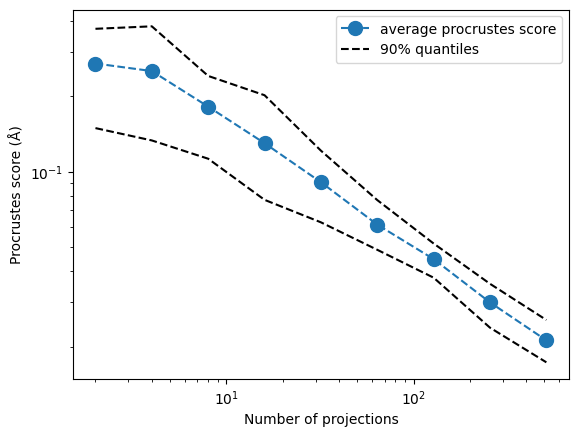

In [6]:
average_scores = np.sum(scores,axis = 1)/M
plt.loglog([2,4,8,16,32,64,128,256,512],average_scores[1:],'--o', markersize = 10, label='average procrustes score')
plt.loglog([2,4,8,16,32,64,128,256,512], np.quantile(scores,0.90,axis = 1)[1:],'--', markersize = 10,c = 'k', label='90% quantiles')
plt.loglog([2,4,8,16,32,64,128,256,512], np.quantile(scores,0.10,axis = 1)[1:],'--', markersize = 10,c = 'k')
plt.legend()
plt.ylabel('Procrustes score (Å)')
plt.xlabel('Number of projections')
#plt.savefig('proc_plot.pdf',dpi = 150)

In [88]:
#slope estimation
from scipy.stats import linregress
print(linregress(np.log([4,8,16,32,64,128,256,512]),np.log(average_scores[2:] ))[0]) #without first point

print(linregress(np.log([2,4,8,16,32,64,128,256,512]),np.log(average_scores[1:] ))[0]) #with first point

-0.5140856167810125
-0.48390201110103165


In [11]:

M = 20
L = 6
projections_vector = [10,50,100]
noise_levels = [0.1,0.2,0.4,0.8,1.2,2.4]
scores_noise_test = np.zeros((3,L,M))
for i in range(3):
    No_projections = projections_vector[i]
    for k in range(L):
        noise_level = noise_levels[k]
        print("running for:"+ str(No_projections)+" projection images, with noise level:"+str(noise_level))    
        for m in range(M):
            np.random.seed(0)
            forward = Forward(No_projections) 

            np.random.seed(i*1000+m*100*i+m*(0.5*i**2-3/2*i + 1))
            data = Data(N, grid,forward_model = forward, blob_size=blob_size, noise_sigma=noise_level) # create data 
    
            optimize = Optimize_list(data,h) #create optimization problem 

            u_full = np.zeros((100,N,3,3))

            for j in range(50):
                u_full = u_full- 0.00001*optimize.grad(u_full)

            out = optim.minimize(fg,u_full.flatten(),jac = True, method = 'L-BFGS-B', options = {'ftol': 1e-25,'gtol':1e-25})

            u_full = out.x.reshape((100,N,3,3))
            R_full = optimize.euler(u_full)


            R1 = R_full[-1]
            template_model = data.template_model
            def_model = forward.act(R1, template_model)
            def_model_pc = forward.M(def_model)

            da = forward.M(def_model)
            scores_noise_test[i,k,m] = procrustes(da2,da)[-1]

        



running for:10 projection images, with noise level:0.1
running for:10 projection images, with noise level:0.2
running for:10 projection images, with noise level:0.4
running for:10 projection images, with noise level:0.8
running for:10 projection images, with noise level:1.2
running for:10 projection images, with noise level:2.4
running for:50 projection images, with noise level:0.1
running for:50 projection images, with noise level:0.2
running for:50 projection images, with noise level:0.4
running for:50 projection images, with noise level:0.8
running for:50 projection images, with noise level:1.2
running for:50 projection images, with noise level:2.4
running for:100 projection images, with noise level:0.1
running for:100 projection images, with noise level:0.2
running for:100 projection images, with noise level:0.4
running for:100 projection images, with noise level:0.8
running for:100 projection images, with noise level:1.2
running for:100 projection images, with noise level:2.4


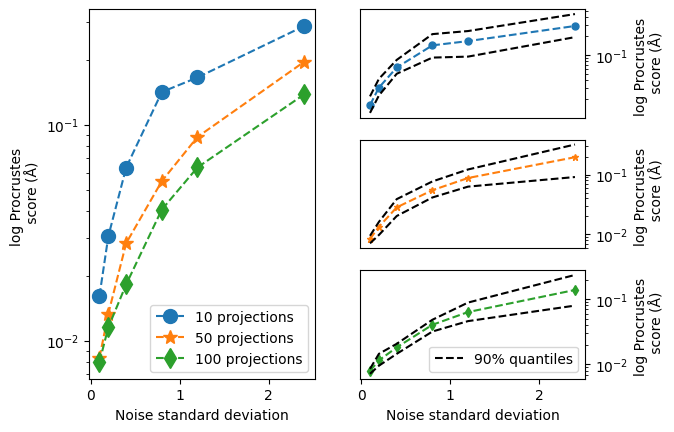

In [8]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

fig=plt.figure()

gs=GridSpec(3,2) # 2 rows, 3 columns

ax1=fig.add_subplot(gs[:,0]) # First row, first column
ax2=fig.add_subplot(gs[0,1]) # First row, second column
ax3=fig.add_subplot(gs[1,1]) # First row, third column
ax4=fig.add_subplot(gs[2,1])


ax2.semilogy([0.1,0.2,0.4,0.8,1.2,2.4],np.mean(scores_noise_test[0,:,:],axis = 1),'--o', markersize = 5, label='10 projections')
ax2.semilogy([0.1,0.2,0.4,0.8,1.2,2.4], np.quantile(scores_noise_test[0,:,:],0.90,axis = 1),'--', markersize = 5,c = 'k', label='90% quantiles')
ax2.semilogy([0.1,0.2,0.4,0.8,1.2,2.4], np.quantile(scores_noise_test[0,:,:],0.10,axis = 1),'--', markersize = 5,c = 'k')

ax2.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('log Procrustes \n score (Å)')
ax2.yaxis.set_label_position("right")

ax3.semilogy([0.1,0.2,0.4,0.8,1.2,2.4],np.mean(scores_noise_test[1,:,:],axis = 1),'--*', markersize = 5,c = 'tab:orange', label='50 projections')
ax3.semilogy([0.1,0.2,0.4,0.8,1.2,2.4], np.quantile(scores_noise_test[1,:,:],0.90,axis = 1),'--', markersize = 5,c = 'k', label='90% quantiles')
ax3.semilogy([0.1,0.2,0.4,0.8,1.2,2.4], np.quantile(scores_noise_test[1,:,:],0.10,axis = 1),'--', markersize = 5,c = 'k')
ax3.yaxis.tick_right()
ax3.set_ylabel('log Procrustes \n  score (Å)')
ax3.yaxis.set_label_position("right")
ax3.get_xaxis().set_visible(False)

ax4.semilogy([0.1,0.2,0.4,0.8,1.2,2.4],np.mean(scores_noise_test[2,:,:],axis = 1),'--d', markersize = 5,c = 'tab:green')
ax4.semilogy([0.1,0.2,0.4,0.8,1.2,2.4], np.quantile(scores_noise_test[2,:,:],0.90,axis = 1),'--', markersize = 5,c = 'k', label='90% quantiles')
ax4.semilogy([0.1,0.2,0.4,0.8,1.2,2.4], np.quantile(scores_noise_test[2,:,:],0.10,axis = 1),'--', markersize = 5,c = 'k')
ax4.yaxis.tick_right()
ax4.legend()
ax4.set_ylabel('log Procrustes \n score (Å)')
ax4.yaxis.set_label_position("right")
ax4.set_xlabel('Noise standard deviation')


ax1.semilogy([0.1,0.2,0.4,0.8,1.2,2.4],np.mean(scores_noise_test[0,:,:],axis = 1),'--o', markersize = 10, label='10 projections')
ax1.semilogy([0.1,0.2,0.4,0.8,1.2,2.4], np.mean(scores_noise_test[1,:,:],axis = 1),'--*', markersize = 10, label='50 projections')
ax1.semilogy([0.1,0.2,0.4,0.8,1.2,2.4], np.mean(scores_noise_test[2,:,:],axis = 1),'--d', markersize = 10,label = '100 projections')

ax1.legend()
ax1.set_ylabel('log Procrustes \n score (Å)')
ax1.set_xlabel('Noise standard deviation')
#plt.savefig('proc_plot_noise.pdf',dpi = 150)


In [7]:
scores = np.loadtxt('scores.txt')
M = 20
scores_noise_test = np.loadtxt('scores_noise_test.txt').reshape((3,6,20))